In [27]:
import numpy as np
import plot_tools as pt
import add_obs
import matplotlib.pyplot as plt
import sys, os, glob, pickle, struct

In [28]:
# Pickle files per redshift

data_paths = glob.glob("/scratch/hc2347/pickles/60/60*.p")

In [29]:
main_pickle_z0 = pt.load_halos_pickle("/scratch/hc2347/pickles/60/main_preload_z0.205.p")

In [30]:
def count_empty(path):
    data = pickle.load( open(path, 'rb'))
    long = 0
    notcenter = 0
    notcenter_ids = []
    
    for i in range(len(data)):
        gal_dict = data[i]
        
        if len(gal_dict) > 1:
            long += 1
        else:
            notcenter += 1
            notcenter_ids.append(gal_dict['ID'])
    return long, notcenter_ids

In [32]:
centered, notcenterlist = count_empty(data_paths[0])

In [35]:
print(len(notcenterlist))
print(centered)

42975
20760


NameError: name 'pynbody' is not defined

In [17]:
def load_halos_pickle(pickle_path):
    
    '''
    Returns pickle as dictionary
    '''
        
    data = pickle.load( open( pickle_path , "rb" ))
    
    output = dict([(str(k),np.zeros(len(data))) for k in data[0]])
    
    for i in range(len(data)):
        gal_dict = data[i]
        
        if gal_dict is not None:
            for key, value in output.items():
                try:
                    value[i] = gal_dict[str(key)]
                except:
                    pass
                
    z = pickle_path.split("_")[1].split(".p")[0]
    print(z)
    output["zred"] = z
    return output

In [18]:
def nihao(quantity, z):
    # Load NIHAO pickles

    NIHAO_PATH = "/scratch/kld8/pickle_NIHAO.p"

    nihao = pickle.load(open(NIHAO_PATH, 'rb'))
    
    retval = []
    
    for (k,v) in nihao.items():
        if z == 0:
            if 1.5765166949677223e-14 in v:
                halo_dict = v[1.5765166949677223e-14]
        if z == 4:
            if 4.021919719675131 in v:
                print('found z=4')
                halo_dict = v[4.021919719675131]
            if 4.0219197196751315 in v:
                halo_dict = v[4.0219197196751315]

        retval.append(halo_dict[quantity])
    
    return retval

In [19]:
def filter_list(a,min_lim,max_lim):
    
    def is_valid(elm):
        return elm > min_lim and elm < max_lim and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(a) - 1, -1, -1):
        if not is_valid(a[idx]):
                a = np.delete(a,idx)
    return a

In [20]:
loaded = load_halos_pickle(data_paths[0])

0.205


In [21]:
print(loaded.keys())

dict_keys(['oxh', 'z_star', 'ndm', 'mgas', 'z_gas', 'ngas', 'sfr_10', 'mdm', 'sfr_100', 'zred', 'mvir', 'ID', 'mgascool', 'nstar', 'npart', 'mstar'])


In [22]:
def plotMoster(entry):
    from pynbody.plot.stars import moster
    from pynbody.plot.stars import behroozi

    fig, ax = plt.subplots(figsize=(7,5))
    
    i = np.where((entry["mstar"] > 1) & (entry["mvir"] > 1))

    x = np.log10(np.array(entry["mvir"][i]))
    y = np.log10(np.array(entry["mstar"][i]))
    
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    
    ax.axis([xmin, xmax, ymin, ymax])
    
    ax.hexbin(x, y, gridsize=50,cmap='Blues', bins='log')
    
    #Moster
    xmasses = np.logspace(np.log10(min(entry['mvir'][i])),1+np.log10(max(entry['mvir'][i])),20)
    ystarmasses, errors = moster(xmasses,float(0.2))
    ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)),color="Black",label="Moster 2013")
    #ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)), linestyle='dashed', color = 'grey')
    #ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)*np.array(errors)), linestyle='dashed', color = 'grey')
    ax.fill_between(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)),y2=np.log10(np.array(ystarmasses)*np.array(errors)),
                    color='grey', alpha=0.2)

    #Behroozi
    b_ystarmasses, b_errors = behroozi(xmasses,float(0.2))
    ax.plot(np.log10(xmasses), np.log10(np.array(b_ystarmasses)),color="seagreen",label="Behroozi 2013")
    ax.fill_between(np.log10(xmasses),np.log10(np.array(b_ystarmasses)/np.array(b_errors)),y2=np.log10(np.array(b_ystarmasses)*np.array(b_errors)),
                    color='seagreen', alpha = 0.2)

    nihao_mstar = nihao('Mstar',0)
    nihao_mhalo = nihao('Mvir',0)

    ax.scatter(np.log10(nihao_mhalo), np.log10(nihao_mstar), color='maroon', label = 'Nihao Classic')
    
    
    xlabel = '$\\rm{log_{10}}(M_{vir}/\\rm M_{\odot})$'
    ylabel = '$\\rm{log_{10}}(M_{\star}/\\rm M_{\odot})$'
    label = '$z \;=\; {}$'.format(0.2)
    c = 'steelblue'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.text(0.4, 0.8, str(len(x)) + " data points",fontsize = 12)

In [25]:
def plotSMF(entry):
    z_simple = entry["zred"].split('.')[0]
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_xlabel('log$_{10}$(M)')
    ax.set_ylabel('dN / dlog$_{10}$(M)')

    ax.set_yscale("log")
    
    pt.plot_mf(ax,filter_list(entry["mstar"],10**7, 10**12),50,entry["zred"])

    add_obs.SMF_Moustakas(ax,z_simple,color='#696969')
    add_obs.SMF_Song(ax,z_simple)
    add_obs.SMF_Duncan(ax,z_simple, color = "#BBBBBB")
    add_obs.SMF_Mortlock(ax, z_simple,continuous = True)
    
    ax.legend()
    
def plotSFRMstar(entry):
    
    i = np.where((entry["mstar"] > 1) & (entry["sfr_100"] > 0))
    
    x = np.log10(np.array(entry["mstar"][i]))
    y = np.log10(np.array(entry["sfr_100"][i]))  
        
    fig, ax = plt.subplots(figsize=(7,5))
    
    xmin = 7
    xmax = 12
    ymin = -1
    ymax = 3
    
    hb = ax.hexbin(x, y,  gridsize = 50, bins = 'log', cmap = 'Blues')
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
    nihao_x = nihao('Mstar',0)
    nihao_y = nihao('SFR_100',0)

    ax.scatter(np.log10(nihao_x), np.log10(nihao_y), color='maroon', label="NIHAO Classic")
    add_obs.SFR_Whitacker(ax, 0.5, color ='#696969')
    ax.legend(title='z = ' + entry['zred'])
    
    xlabel = "$M_{vir}$"
    ylabel = "$log(SFR) [M_{\odot} yr^{-1}]"
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


started


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


14
14


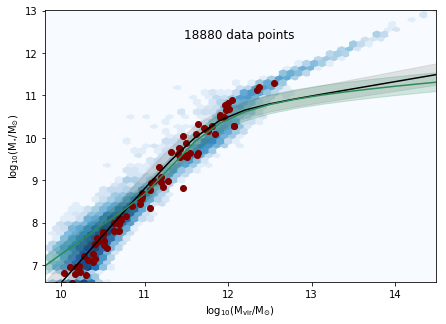

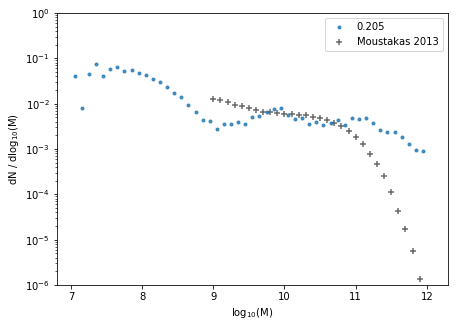

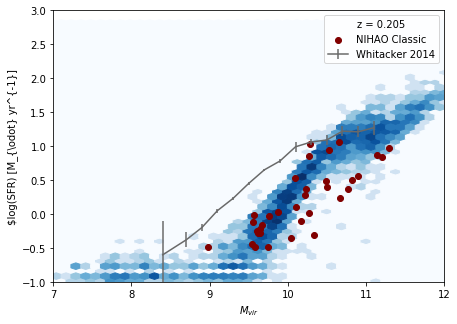

In [26]:
plotMoster(loaded)
plotSMF(loaded, 0.2)
plotSFRMstar(loaded)

In [ ]:
for path in data_paths:
    load = load_halos_pickle(path)
    
    plotMoster(load)
    